In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, Column
from astropy.io import fits

import seaborn as sns
from speclite import filters

from desispec.io.util import write_bintable
from desisim.io import read_basis_templates, empty_metatable
from desisim.templates import BGS

sns.set(style='white', font_scale=1.6, palette='deep')
%matplotlib inline

LIGHT = 2.99792458E5  #- speed of light in km/s

In [4]:
# Read the mock catalog.
cat = h5py.File('galaxy_catalogue_0.hdf5')
cat['Data'].values()

[<HDF5 dataset "abs_mag": shape (5611282,), type "<f8">,
 <HDF5 dataset "app_mag": shape (5611282,), type "<f8">,
 <HDF5 dataset "dec": shape (5611282,), type "<f8">,
 <HDF5 dataset "g_r": shape (5611282,), type "<f8">,
 <HDF5 dataset "ra": shape (5611282,), type "<f8">,
 <HDF5 dataset "z_cos": shape (5611282,), type "<f8">,
 <HDF5 dataset "z_obs": shape (5611282,), type "<f8">]

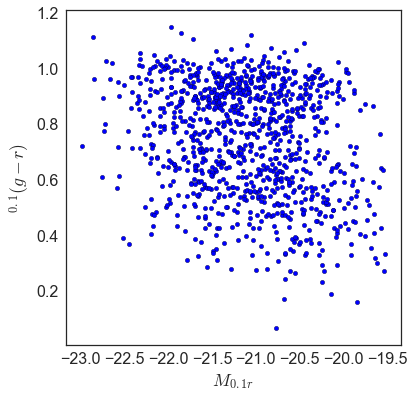

In [15]:
# Grab a subset of the galaxies and pull out their redshifts, apparent magnitudes, 
# and rest-frame colors and magnitudes.  All bands are SDSS and the rest-frame bands
# are band-shifted to z=0.1.
ngal = 1000

rmabs = cat['Data']['abs_mag'][:ngal]
gr = cat['Data']['g_r'][:ngal]
rmag = cat['Data']['app_mag'][:ngal]
zobs = cat['Data']['z_obs'][:ngal]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
_, _, _ = ax1.hist(rmag, bins=25)
ax1.set_ylabel('Number of Galaxies per bin')
ax1.set_xlabel('SDSS r (AB mag)')
ax1.set_xlim(17, 20)

_, _, _ = ax2.hist(zobs, bins=25)
ax2.set_xlabel('Redshift')
ax2.set_xlim(0, 0.6)

fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(rmabs, gr)
ax1.set_ylabel('$^{0.1}(g -r)$')
ax1.set_xlabel('$M_{0.1r}$')
ax1.margins(0.05)

In [ ]:
# Read the basis templates and initialize the output metadata table.
npergal = 50
zmin, zmax = np.min(z), np.max(z)

baseflux, basewave, basemeta = read_basis_templates('BGS')
meta = empty_metatable(objtype='BGS', nmodel=ngal)

bgs = BGS(minwave=3000, maxwave=11000.0)

for igal in range(ngal):
    flux, wave, meta = bgs.make_templates(npergal, zrange=(zmin, zmax),
                                          nocolorcuts=True)

In [2]:
cat = fits.getdata('allsky_galaxia_desi_3250p100.fits', ext=1)[:1000]
print(cat.columns)
nstar = len(cat)

ColDefs(
    name = 'X'; format = 'E'; unit = 'kpc'
    name = 'Y'; format = 'E'; unit = 'kpc'
    name = 'Z'; format = 'E'; unit = 'kpc'
    name = 'l'; format = 'E'; unit = 'deg'
    name = 'b'; format = 'E'; unit = 'deg'
    name = 'RA'; format = 'D'; unit = 'deg'
    name = 'DEC'; format = 'D'; unit = 'deg'
    name = 'pm_l'; format = 'E'
    name = 'pm_b'; format = 'E'
    name = 'pm_RA'; format = 'E'
    name = 'pm_DEC'; format = 'E'
    name = 'pm_l_kms'; format = 'E'; unit = 'km s-1'
    name = 'pm_b_kms'; format = 'E'; unit = 'km s-1'
    name = 'pm_RA_kms'; format = 'E'; unit = 'km s-1'
    name = 'pm_DEC_kms'; format = 'E'; unit = 'km s-1'
    name = 'v_helio'; format = 'E'; unit = 'km s-1'
    name = 'd_helio'; format = 'E'; unit = 'kpc'
    name = 'DM'; format = 'E'; unit = 'mag'
    name = 'ABV'; format = 'E'; unit = 'mag'
    name = 'SDSSu_true_nodust'; format = 'E'; unit = 'mag'
    name = 'SDSSu_true'; format = 'E'; unit = 'mag'
    name = 'SDSSu_obs'; format = 'E'; un

In [3]:
# Build the input Table needed by desisim.templates.
input_data = Table()
input_data.add_column(Column(name='REDSHIFT', length=nstar, dtype='f4'))
input_data.add_column(Column(name='MAG', length=nstar, dtype='f4'))
input_data.add_column(Column(name='TEFF', length=nstar, dtype='f4'))
input_data.add_column(Column(name='LOGG', length=nstar, dtype='f4'))
input_data.add_column(Column(name='FEH', length=nstar, dtype='f4'))

normfilter = 'sdss2010-r'
input_data['REDSHIFT'] = cat['v_helio'] / LIGHT
input_data['MAG'] = cat['SDSSr_true_nodust']
input_data['TEFF'] = 10**cat['teff']
input_data['LOGG'] = cat['logg']
input_data['FEH'] = cat['FeH']

print(input_data)

  REDSHIFT     MAG     TEFF    LOGG      FEH    
------------ ------- ------- ------- -----------
 6.01848e-05 15.8917 3282.58 5.13229  -0.0315856
 7.99531e-06 15.8664 3312.49 5.14478 -0.00470402
 1.74716e-05 15.5964  3334.0 5.10969    0.125893
 5.70486e-05 15.3146  3410.2 5.09782  0.00320513
 9.38985e-05 15.8247 3458.58 5.05803     0.09498
 6.27923e-07 16.7426 3363.57 5.13803  -0.0633323
  6.7137e-05 15.4234 3541.03 5.01888    0.117763
 1.90811e-05 15.9689 3328.64 5.12838   0.0616664
 -3.0621e-05 16.0427 3437.96 5.08739   0.0287824
 4.54792e-05 16.8698 3183.28 5.06934   0.0716745
         ...     ...     ...     ...         ...
-2.19293e-05 15.5301 4670.36 4.63824    0.134668
 1.39156e-05  15.633 4796.29 4.66383   -0.198207
 0.000101043 16.0687 4532.31 4.69746   -0.137685
 7.15131e-05 16.0526 4577.26 4.69566   -0.176918
 4.90442e-05 15.5463 4729.08 4.61933    0.174833
 5.23339e-05 16.9829 4197.07 4.78854   -0.110437
 0.000110215 16.7676 4273.42 4.73282    0.130931
 0.000110136 16.7092

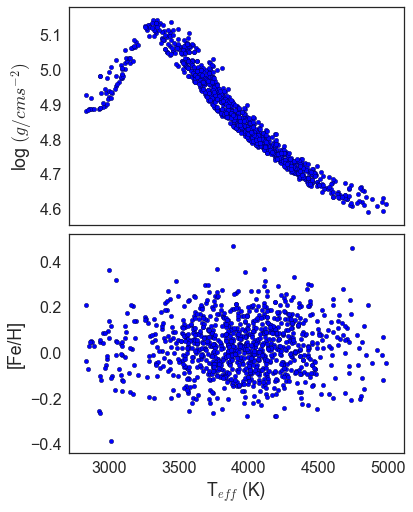

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
_, _, _ = ax1.hist(input_data['MAG'])
ax1.set_ylabel('Number of Stars per bin')
ax1.set_xlabel('SDSS r (AB mag)')

_, _, _ = ax2.hist(input_data['REDSHIFT'] * LIGHT)
ax2.set_xlabel('Heliocentric Redshift')

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
ax1.scatter(input_data['TEFF'], input_data['LOGG'])
ax1.set_ylabel('log $(g / cm s^{-2})$')
ax1.margins(0.05)

ax2.scatter(input_data['TEFF'], input_data['FEH'])
ax2.set_xlabel('T$_{eff}$ (K)')
ax2.set_ylabel('[Fe/H]')
ax2.margins(0.05)
fig.subplots_adjust(hspace=0.04)

In [5]:
seed = 123
star = STAR(normfilter=normfilter)
flux, wave, meta = star.make_templates(seed=seed, input_data=input_data)

INFO:io.py:611:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.2/star_templates_v2.1.fits


INFO:DESI:Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.2/star_templates_v2.1.fits


In [6]:
print(meta)

OBJTYPE TEMPLATEID    SEED      REDSHIFT  ... AGE    TEFF    LOGG      FEH    
                                          ... Gyr     K     m / s2            
------- ---------- ---------- ----------- ... ---- ------- ------- -----------
   STAR          0 2991312382 6.01848e-05 ... -1.0 3282.58 5.13229  -0.0315856
   STAR          1 3062119789 7.99531e-06 ... -1.0 3312.49 5.14478 -0.00470402
   STAR          2 1228959102 1.74716e-05 ... -1.0  3334.0 5.10969    0.125893
   STAR          3 1840268610 5.70486e-05 ... -1.0  3410.2 5.09782  0.00320513
   STAR          4  974319580 9.38985e-05 ... -1.0 3458.58 5.05803     0.09498
   STAR          5 2967327842 6.27923e-07 ... -1.0 3363.57 5.13803  -0.0633323
   STAR          6 2367878886  6.7137e-05 ... -1.0 3541.03 5.01888    0.117763
   STAR          7 3088727057 1.90811e-05 ... -1.0 3328.64 5.12838   0.0616664
   STAR          8 3090095699 -3.0621e-05 ... -1.0 3437.96 5.08739   0.0287824
   STAR          9 2109339754 4.54792e-05 ... -1.0 3

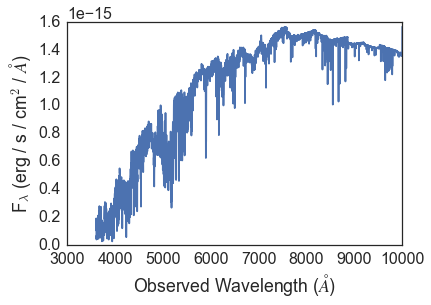

In [7]:
plt.plot(wave, flux[0, :])
plt.xlabel('Observed Wavelength ($\AA$)')
plt.ylabel('F$_{\lambda}$ (erg / s / cm$^{2}$ / $\AA$)')